In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls
%cd drive/MyDrive/9444/group_ass/VOC2012

drive  sample_data
/content/drive/MyDrive/9444/group_ass/VOC2012


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 31.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [5]:
import os
import xml.etree.ElementTree as ET
# from ultralytics import YOLO
from collections import defaultdict, Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split, Subset
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, Normalize, ElasticTransform, ColorJitter, BboxParams
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from copy import deepcopy
import matplotlib.patches as patches
import torchvision.transforms as T
import shutil

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Data Preprocessing
- Our dataset is from ScienceDB (scidb.cn), the url is : https://www.scidb.cn/en/s/6bq2M3</br>

- Datasets are in PASCAL VOC format</br>
- To facilitate uniform data reading, we point the current working directory to `/root` </br>
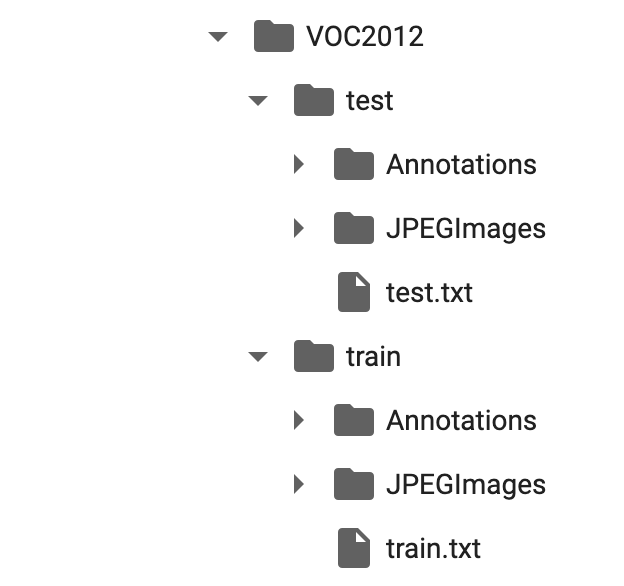

In [6]:
os.chdir('/content/drive/MyDrive/9444/group_ass')

In [ ]:
# set the new dataset path
# root_path = './new_dumpsite_data'
# train_file_Annotations = os.path.join(root_path, "train", "Annotations")
# test_file_Annotations = os.path.join(root_path, "test", "Annotations")

# # Create directories if they do not exist
# os.makedirs(train_file_Annotations, exist_ok=True)
# os.makedirs(test_file_Annotations, exist_ok=True)

# print(os.getcwd())
# print(f"Train Annotations directory: {train_file_Annotations}")
# print(f"Test Annotations directory: {test_file_Annotations}")

/content/drive/MyDrive/9444/group_ass
Train Annotations directory: ./new_dumpsite_data/train/Annotations
Test Annotations directory: ./new_dumpsite_data/test/Annotations


In [7]:
# convert annotation files to find How many labels are there
def convert_annotation_find_labels(path):
  labels = []
  for each_xml in os.listdir(path):
      pic_xml = os.path.join(path, each_xml)
      tree = ET.parse(pic_xml)
      root = tree.getroot()
      for ele in root.findall('object'):
          label = ele.find('name').text
          labels.append(label)
  set_labels = set(labels)
  print(path, set_labels)
  return labels

train_object_labels = convert_annotation_find_labels('VOC2012/train/Annotations')
test_object_labels = convert_annotation_find_labels('VOC2012/test/Annotations')

VOC2012/train/Annotations {'construction waste', 'domestic garbage', 'mining waste', 'agriculture forestry', 'industry waste', 'disposed garbage'}
VOC2012/test/Annotations {'construction waste', 'agriculture forestry', 'domestic garbage', 'disposed garbage'}


In [8]:
with open('./label_map.json', 'r') as json_file:
  label_map = json.load(json_file)
label_name = {v : k for k, v in label_map.items()}

In [9]:
# Number of statistics for each label
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_labels):
  name_number[label_map[class_name]] += 1
  train_object_labels[index] = label_map[class_name]
print('train_object_labels', train_object_labels)

train_object_labels [0, 0, 0, 2, 0, 5, 5, 5, 5, 0, 0, 0, 0, 5, 0, 5, 5, 0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0, 2, 0, 2, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 2, 0, 0, 0, 0, 0, 5, 5, 0, 2, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 0, 5, 2, 0, 0, 0, 5, 2, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5

In [9]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()), name="train_labels_distribution")
df

,train_labels_distribution
domestic garbage,2301
agriculture forestry,247
construction waste,581
disposed garbage,9
mining waste,1
industry waste,1


## 1.2 Calculation of category weights based on imbalances

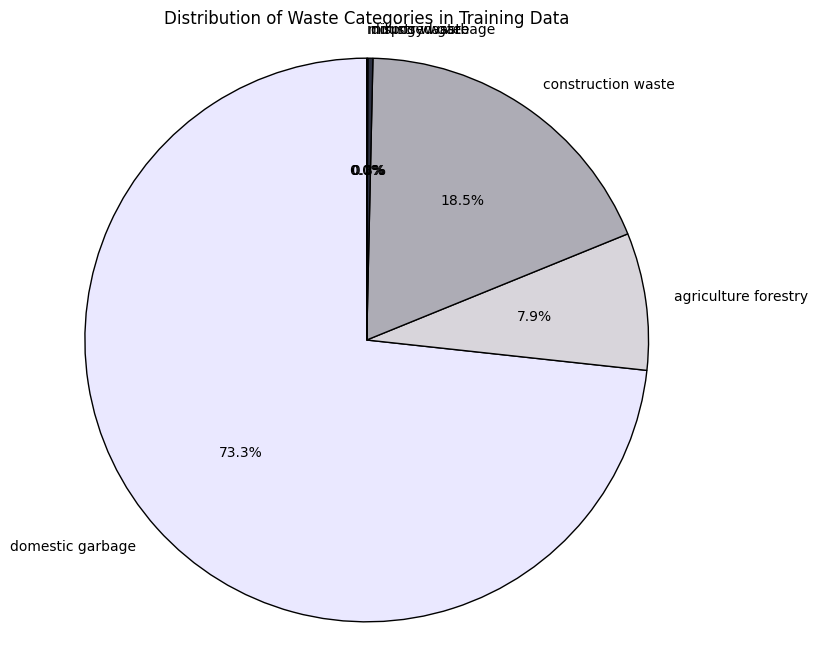

In [ ]:
# Percentage of each category of visualization
# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: to make the pie chart bigger

plt.pie([2301, 247, 581, 9, 1, 1],
    labels=list(label_name[name] for name in name_number.keys()),
    autopct='%1.1f%%',  # Display percentage with one decimal place
    startangle=90,      # Rotate the start of the pie chart
    wedgeprops={'edgecolor': 'black'},  # Add border to slices for clarity
    colors=['#EAE8FF','#D8D5DB','#ADACB5','#2D3142', '#B0D7FF', '#FFB3E6'])  # Custom colors

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title (Optional)
plt.title('Distribution of Waste Categories in Training Data')

# Show the pie chart
plt.show()


In [10]:
def check_image_annotation_consistency(image_dir, annotation_dir):
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(image_dir)])
    annotation_files = set([os.path.splitext(f)[0] for f in os.listdir(annotation_dir)])

    missing_images = annotation_files - image_files
    missing_annotations = image_files - annotation_files

    if missing_images:
        print(f"Missing images for annotations: {missing_images}")
    if missing_annotations:
        print(f"Missing annotations for images: {missing_annotations}")
    if not missing_images and not missing_annotations:
        print("All images and annotations are consistent.")

# Checking the consistency of the training and test sets
check_image_annotation_consistency('VOC2012/train/JPEGImages', 'VOC2012/train/Annotations')
check_image_annotation_consistency('VOC2012/test/JPEGImages', 'VOC2012/test/Annotations')

All images and annotations are consistent.
All images and annotations are consistent.


## 1.3 Data Processing

As shown in the figure above, due to the uneven distribution of each category in the training set, it will lead to unfair training results, so we use data enhancement, category weight adjustment, and oversampling to make the proportion of images in each category reach a relative balance
- Data augmentation: data augmentation (rotation, translation, scaling, etc.) is applied to small categories to expand the sample size.
- **Category** weighting: assign larger weights to small categories during training to reduce the impact of category imbalance on the model.




In [ ]:
def save_augmented_annotation(xml_path, boxes, labels, output_annotation_path):
  """
  保存增强后的注释信息。
  :param xml_path: 原始 XML 文件的路径
  :param boxes: 增强后的边界框列表
  :param labels: 增强后的标签列表
  :param output_annotation_path: 输出 XML 文件路径
  """
  # 解析原始 XML 文件
  tree = ET.parse(xml_path)
  root = tree.getroot()

  # 删除旧的 object 节点（原始边界框和标签信息）
  for obj in root.findall("object"):
    root.remove(obj)

  # 根据增强后的边界框和标签信息创建新的 object 节点
  for label, box in zip(labels, boxes):
    obj = ET.SubElement(root, "object")
    name = ET.SubElement(obj, "name")
    name.text = str(label)  # 使用映射后的标签名称

    bndbox = ET.SubElement(obj, "bndbox")
    xmin = ET.SubElement(bndbox, "xmin")
    xmin.text = str(int(box[0]))  # x_min 坐标
    ymin = ET.SubElement(bndbox, "ymin")
    ymin.text = str(int(box[1]))  # y_min 坐标
    xmax = ET.SubElement(bndbox, "xmax")
    xmax.text = str(int(box[2]))  # x_max 坐标
    ymax = ET.SubElement(bndbox, "ymax")
    ymax.text = str(int(box[3]))  # y_max 坐标

  # 将更新后的 XML 保存到输出路径
  tree.write(output_annotation_path, encoding="utf-8", xml_declaration=True)

In [ ]:
class GarbageDataset(Dataset):
  def __init__(self, root, mode, output_dir=None, transforms=None, split_ratio=0.2, shuffle=True):
    self.root = root
    self.mode = mode
    self.transforms = transforms
    self.image_dir = os.path.join(root, 'JPEGImages')
    self.annotation_dir = os.path.join(root, 'Annotations')
    self.output_image_dir = os.path.join(output_dir, mode, "JPEGImages")  # transform image saved directories
    self.output_annotation_dir = os.path.join(output_dir, mode, 'Annotations')  # transform annotation saved directories

    # If output_dir is specified and the directory does not exist, create the directory
    # Create output directories if they don't exist
    os.makedirs(self.output_image_dir, exist_ok=True)
    os.makedirs(self.output_annotation_dir, exist_ok=True)

    # plan1: split inside
    # Load image IDs from text file
    # text_file = os.path.join(root, 'train.txt')
    # with open(text_file, 'r') as f:
    #   self.img_ids = f.read().strip().split()

    # # Split the dataset into train and validation sets
    # train_ids, val_ids = train_test_split(self.img_ids, train_size=split_ratio, shuffle=shuffle, random_state=42)

    # if mode == 'train':
    #   self.img_ids = train_ids
    # elif mode == 'valid':
    #   self.img_ids = val_ids
    # elif mode == 'test':
    #   text_file = os.path.join(root, 'test.txt')
    #   with open(text_file, 'r') as f:
    #       self.img_ids = f.read().strip().split()
    # else:
    #   raise ValueError("Invalid mode. Use 'train', 'valid', or 'test'.")

    # plan2:
    # Load image IDs from text file
    if mode == 'train':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'valid':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'test':
      text_file = os.path.join(root, 'test.txt')
    else:
      raise ValueError("Invalid mode. Use 'train', 'valid', or 'test'.")

    with open(text_file, 'r') as f:
      self.img_ids = f.read().strip().split()

  def __len__(self):
        return len(self.img_ids)

  def __getitem__(self, index):
    # These two categories were not present in the test set and were simply ignored during data processing @r.mondol@unsw.edu.au
    ignored_labels = {'mining waste', 'industry waste'}

    img_id = self.img_ids[index]
    img_path = os.path.join(self.image_dir, img_id + '.jpg')
    annotation_path = os.path.join(self.annotation_dir, img_id + '.xml')

    img = np.array(Image.open(img_path).convert('RGB'))

    # Parse the XMl annotation files
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Initialize lists for bounding boxes and labels
    boxes = []
    labels = []

    # Iterate over each obj in the XML files
    for obj in root.findall('object'):
        label = obj.find('name').text

        # Mapping the obj name to a label
        if label not in label_map or label in ignored_labels:
          continue  # skip labels that are not in the label_map
        else:
          labels.append(label_map[label])

        # Extract bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Create a list for the bounding box coordinates
        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
    # Convert lists to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    # Prepare the final target dictionary containing bounding boxes and labels
    target = {
        "boxes": boxes,
        "labels": labels
    }

    if self.transforms is not None:
      if self.mode == "train":
        while True:
          img_copy, target_copy = img.copy(), target.copy()
          transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
          img_copy = transformed['image']
          target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
          target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
          if torch.numel(target_copy['boxes']) > 0:
            img, target = img_copy, target_copy
            break
      else:
        img = self.transforms(img)

      if self.output_image_dir and self.output_annotation_dir:
        output_img_path = os.path.join(self.output_image_dir, img_id + ".jpg")
        processed_image = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert to uint8 and back to RGB
        cv2.imwrite(output_img_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

        # Save the augmented XML annotation
        output_annotation_path = os.path.join(self.output_annotation_dir, img_id + '.xml')
        save_augmented_annotation(annotation_path, target['boxes'].tolist(), target['labels'].tolist(), output_annotation_path)
        tree.write(output_annotation_path, encoding='utf-8', xml_declaration=True)

      return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}
  def load_annotations(self):
    """
    load_annotations function attempt to store the classes appeared in each image to recompute the image weight
    Returns:
        list : the labels in each image
    """
    # data_infos = []
    # for index in self.img_ids:
    #   ann_path = os.path.join(self.annotation_dir, f"{index}.xml")
    #   tree = ET.parse(ann_path)
    #   root = tree.getroot()
    #   temp_labels = []
    #   for obj in root.findall("object"):
    #     label = obj.find("name").text
    #     temp_labels.append(label_map[label])
    #   data_infos.append(temp_labels)
    #   print(f'data_infos ({self.mode}): Image {idx + 1}/{len(self.img_ids)} processed - {index}')
    # return data_infos

    data_infos = []
    for idx, index in enumerate(self.img_ids):
      ann_path = os.path.join(self.annotation_dir, f"{index}.xml")
      tree = ET.parse(ann_path)
      root = tree.getroot()
      temp_labels = []
      for obj in root.findall("object"):
        label = obj.find("name").text
        temp_labels.append(label_map[label])
      data_infos.append(temp_labels)

      # Move the print inside the loop to print each image's data as it's processed
      if idx % 100 == 0:
        print(f'data_infos ({self.mode}): Image {idx + 1}/{len(self.img_ids)} processed - {index}')
    return data_infos



In [17]:
transform = {
    "train" : Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=90, p=0.5),
    Rotate(limit=-90, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=BboxParams(format='pascal_voc', label_fields=['labels'])),
    "test" : T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

## 1.4 Split Train Dataset to train dataset and valitation dataset

In [18]:
train_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])

torch.manual_seed(42)
np.random.seed(42)
validation_split = 0.2
dataset_size = len(train_dataset)
print('dataset_size: ', dataset_size)

validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split train_dataset into train and validation indices
train_indices, val_indices = random_split(range(dataset_size), [train_size, validation_size])

train_indices = list(train_indices.indices)
val_indices = list(val_indices.indices)

# Create training and validation subsets from train_dataset
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

for idx in range(len(train_subset)):
  sample = train_subset[idx]
  if idx % 100 == 0:
    print(f"Train Dataset Processed {idx + 1}/{len(train_subset)}: Image ID {train_dataset.img_ids[train_subset.indices[idx]]}")
  # if idx == 10:
  #   break
for idx in range(len(val_subset)):
  sample = val_subset[idx]
  if idx % 100 == 0:
    print(f"Validation Dataset Processed {idx + 1}/{len(val_subset)}: Image ID {train_dataset.img_ids[val_subset.indices[idx]]}")
  # if idx == 10:
  #   break

dataset_size:  2671
Train Dataset Processed 1/2137: Image ID CS1872
Train Dataset Processed 101/2137: Image ID 60317
Train Dataset Processed 201/2137: Image ID LN2892


KeyboardInterrupt: 

# Plan two
train_dataloader

In [ ]:
train_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])
val_dataset = GarbageDataset(root='VOC2012/train', mode='valid', output_dir='./new_dumpsite_data', transforms=transform["test"])

torch.manual_seed(42)
np.random.seed(42)
validation_split = 0.2
dataset_size = len(train_dataset)

validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

train_indices, val_indices = random_split(range(dataset_size), [train_size, validation_size])

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

for idx in range(len(train_subset)):
  sample = train_subset[idx]
  if idx % 100 == 0:
    print(f"Train Dataset Processed {idx + 1}/{len(train_subset)}: Image ID {train_dataset.img_ids[train_subset.indices[idx]]}")
  # if idx == 10:
  #   break
for idx in range(len(val_subset)):
  sample = val_subset[idx]
  if idx % 100 == 0:
    print(f"Validation Dataset Processed {idx + 1}/{len(val_subset)}: Image ID {train_dataset.img_ids[val_subset.indices[idx]]}")
  # if idx == 10:
  #   break

Train Dataset Processed 1/2137: Image ID CS1872
Train Dataset Processed 101/2137: Image ID 60317
Train Dataset Processed 201/2137: Image ID LN2892


In [ ]:
def collate_fn(batch):
  images = []
  targets = []
  for obj in batch:
      if obj:
          images.append(obj['image'])
          targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
  images = torch.stack(images, dim=0)
  return images, targets

n_c = defaultdict(int)

# Loop through the indices in train_subset
for idx in train_subset.indices:
    labels = train_dataset[idx]['labels']

    # Check if labels is a tensor or list, and handle multiple labels
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()  # Convert tensor to list

    # Iterate through each label (in case of multiple labels per image)
    for label in labels:
        n_c[int(label)] += 1

# Calculate weights based on label frequencies
classes_weights = {key: 1.0 / value for key, value in n_c.items()}

annotations = train_dataset.load_annotations()
image_weights = []
for img_classes in annotations:
    img_weight = classes_weights[img_classes[0]]
    image_weights.append(img_weight)
np.save('image_weights.npy', np.array(image_weights))

image_weights = np.load("image_weights.npy")

train_image_weights = [image_weights[i] for i in train_subset.indices]
sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=len(train_image_weights), replacement=True)

train_dataloader = DataLoader(train_subset, batch_size=12, collate_fn=collate_fn, sampler=sampler)

val_dataloader = DataLoader(val_subset, batch_size=8, collate_fn=collate_fn)

test_dataset = GarbageDataset(root='VOC2012/test', mode='test', output_dir='./new_dumpsite_data', transforms=transform["test"])
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)


# test 看一下test_dataset的输出结构
print('test_dataset: ', test_dataset)

for idx in range(len(test_dataset)):
  sample = test_dataset[idx]
  if idx % 100 == 0:
    print(f"Train Dataset Processed {idx + 1}/{len(test_dataset)}: Image ID {test_dataset.img_ids[idx]}")
  # if idx == 10:
  #   break


def plot_label_distribution(dataloader, label_map):
    # 统计标签分布
    label_counts = defaultdict(int)

    # 迭代批次并统计标签数量
    for batch in dataloader:
        for labels in batch[1]:  # batch[1] 中包含的是 target，即标签
            for label in labels['labels']:
                label_counts[label.item()] += 1

    # 显示标签分布
    labels, counts = zip(*label_counts.items())
    labels = [list(label_map.keys())[list(label_map.values()).index(lab)] for lab in labels]  # 将标签映射回名称

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title("Label Distribution in Sampled Batches")

    # Add counts above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Display count

    plt.show()

# 调用 plot_label_distribution 检查 train_dataloader 的标签分布
plot_label_distribution(train_dataloader, label_map)



In [49]:
# plan to create dataloader and testloader

# Calculate label counts across the entire dataset to account for rare classes
annotations = train_dataset.load_annotations()  # this should give the labels for each image in the full training dataset
label_count = defaultdict(int)

for img_classes in annotations:
  for label in img_classes:
      label_count[label] += 1

# Compute weights as the inverse frequency of each label
labels_weights = {key: 1.0 / value for key, value in label_count.items()}

# Optionally normalize the weights if the differences are extreme
max_weight = max(labels_weights.values())
labels_weights = {key: weight / max_weight for key, weight in labels_weights.items()}


# Calculate image weights
# Calculate image weights using harmonic mean, emphasizing images with rare classes
image_weights = []
for img_classes in annotations:
  if img_classes:  # to avoid division by zero in case of empty labels
    img_weight = len(img_classes) / sum(labels_weights[label] for label in img_classes)
    image_weights.append(img_weight)
  else:
    image_weights.append(1.0)  # Assign a neutral weight to images with no labels (if any)
np.save('image_weights.npy', np.array(image_weights))


# Ensure annotations and train_dataset match
assert len(annotations) == len(train_dataset), "Inconsistent size of annotations and train_subset"

# Create weights specifically for the training subset
train_image_weights = [image_weights[i] for i in train_indices]
assert len(train_image_weights) == len(train_subset), "train_image_weights length mismatch with train_subset"

# Adjust num_samples for improved class balance in each epoch
sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=2 * len(train_subset), replacement=True)
train_dataloader = DataLoader(train_subset, batch_size=12, collate_fn=collate_fn, sampler=sampler)

# # Generate `train_image_weights` by ensuring each sample has a corresponding weight
# train_image_weights = [image_weights[i] for i in range(len(train_dataset))]

# # Use `train_indices` to create `train_subset_weights` based on the subset
# train_subset_weights = [train_image_weights[i] for i in train_indices]

# # Verify that lengths match
# print("Length of train_subset_weights:", len(train_subset_weights))
# print("Length of train_subset:", len(train_subset))
# assert len(train_subset_weights) == len(train_subset), "train_subset_weights length mismatch with train_subset"

# # Creating WeightedRandomSampler with new weights
# sampler = WeightedRandomSampler(weights=train_subset_weights, num_samples=len(train_subset_weights), replacement=True)

# # Update train_dataloader
# train_dataloader = DataLoader(train_subset, batch_size=12, collate_fn=collate_fn, sampler=sampler)

# Validation and test dataloaders
val_dataloader = DataLoader(val_subset, batch_size=8, collate_fn=collate_fn)

test_dataset = GarbageDataset(root='VOC2012/test', mode='test', output_dir='./new_dumpsite_data', transforms=transform["test"])
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [46]:
# test2
subset_label_count = defaultdict(int)
for idx in train_indices:
    img_classes = annotations[idx]
    for label in img_classes:
        subset_label_count[label] += 1

# 根据标签频率的倒数生成新的 labels_weights
subset_labels_weights = {key: 1.0 / value for key, value in subset_label_count.items()}

# 重新生成 train_subset_weights
train_subset_weights = []
for idx in train_indices:
    img_classes = annotations[idx]
    img_weight = np.mean([subset_labels_weights[label] for label in img_classes])
    train_subset_weights.append(img_weight)

# 验证 train_subset_weights 长度
print("Length of train_subset_weights:", len(train_subset_weights))
print("Length of train_subset:", len(train_subset))
assert len(train_subset_weights) == len(train_subset), "train_subset_weights length mismatch with train_subset"

# 创建新的 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=train_subset_weights, num_samples=len(train_subset_weights), replacement=True)

# 更新 train_dataloader
train_dataloader = DataLoader(train_subset, batch_size=12, collate_fn=collate_fn, sampler=sampler)


Length of train_subset_weights: 2137
Length of train_subset: 2137


In [49]:
len(annotations)

2671

Total dataset size: 2671
Train split size: 2137
Validation split size: 534
Train indices: <torch.utils.data.dataset.Subset object at 0x7bce541c55a0>
Validation indices: <torch.utils.data.dataset.Subset object at 0x7bce541c4f10>
Length of train_image_weights: 2137
Length of train_dataset: 2671
Length of train_subset: 2137


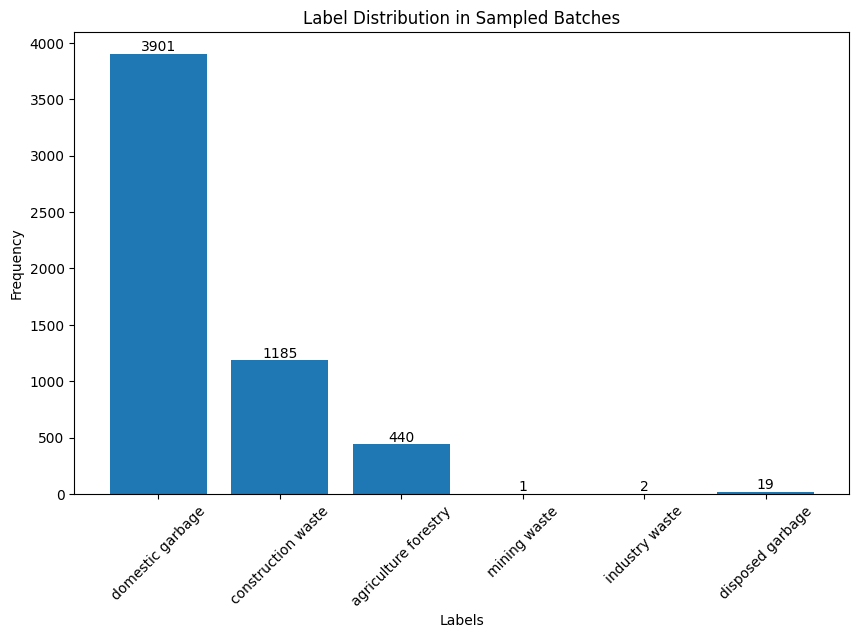

In [57]:
# Check train and validation split
dataset_size = len(train_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

train_indices, val_indices = random_split(range(dataset_size), [train_size, validation_size])

# Debug: Print sizes to check for consistency
print("Total dataset size:", dataset_size)
print("Train split size:", len(train_indices))
print("Validation split size:", len(val_indices))
print("Train indices:", train_indices)
print("Validation indices:", val_indices)

# Check train_image_weights consistency
print("Length of train_image_weights:", len(train_image_weights))
print("Length of train_dataset:", len(train_dataset))
print("Length of train_subset:", len(train_subset))
assert len(train_image_weights) == len(train_subset), "train_image_weights length mismatch with train_subset"
# assert len(train_subset_weights) == len(train_subset), "train_image_weights length mismatch with train_subset"



def plot_label_distribution(dataloader, label_map):
    # 统计标签分布
    label_counts = defaultdict(int)

    # 迭代批次并统计标签数量
    for batch in dataloader:
        for labels in batch[1]:  # batch[1] 中包含的是 target，即标签
            for label in labels['labels']:
                label_counts[label.item()] += 1

    # 显示标签分布
    labels, counts = zip(*label_counts.items())
    labels = [list(label_map.keys())[list(label_map.values()).index(lab)] for lab in labels]  # 将标签映射回名称

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title("Label Distribution in Sampled Batches")

    # Add counts above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Display count

    plt.show()

# 调用 plot_label_distribution 检查 train_dataloader 的标签分布
plot_label_distribution(train_dataloader, label_map)



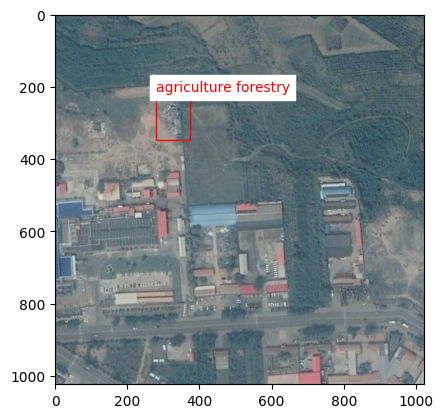

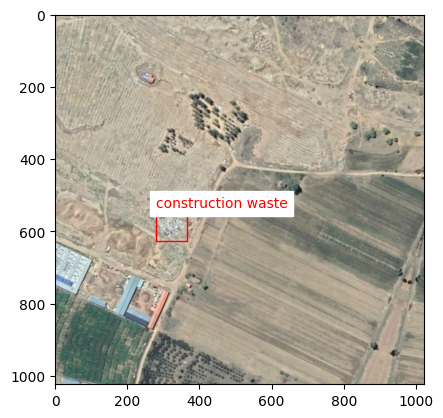

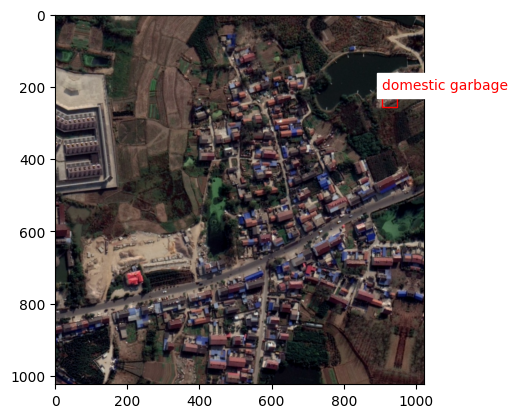

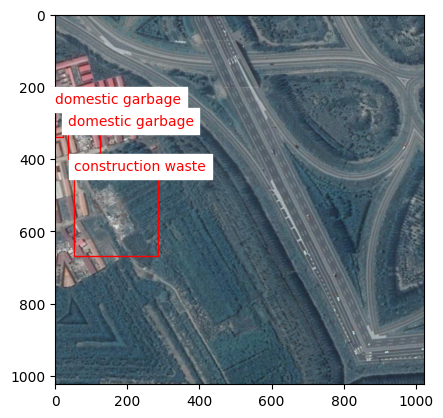

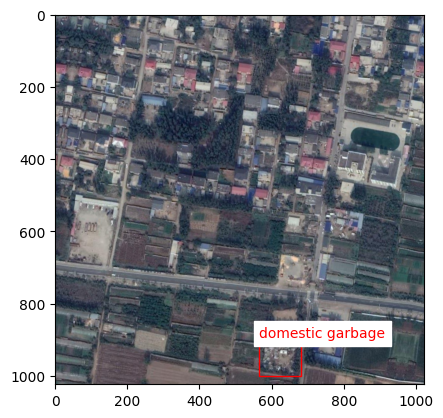

In [81]:
def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  mean = torch.tensor(mean)[:, None, None]
  std = torch.tensor(std)[:, None, None]
  return image * std + mean

# Functions for visualizing images and their bounding boxes
def visualize_sample(image, boxes, labels, label_map):
  fig, ax = plt.subplots(1)
  # Normalize image to the range [0, 1]
  image = unnormalize(image).permute(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
  image = image / 255.0 if image.dtype == torch.uint8 else image.clip(0, 1)

  ax.imshow(image)

  for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, label_map[label.item()], color='red', fontsize=10, backgroundcolor="white")

  plt.show()

# 设置参数
batch_size = 1  # Load one image at a time
subset_size = 5  # Take 5 images for testing

# load and test
subset_indices = list(range(subset_size))  # Get indices of the first 5 images
subset = Subset(train_dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False)


for batch in dataloader:
  image, boxes, labels = batch['image'][0], batch['boxes'][0], batch['labels'][0]
  visualize_sample(image, boxes, labels, label_name)


## 2. Model Part
## 2.1 Model one: [YOLOV8](https://github.com/ultralytics/ultralytics)

In [83]:
def convert_xml_to_yolo(xml_folder, output_folder, label_map):
    # 创建输出文件夹（如果不存在）
    os.makedirs(os.path.join(output_folder, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'labels/test'), exist_ok=True)

    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith('.xml'):
            continue

        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        # 提取图像文件名、宽度和高度
        filename = root.find('filename').text
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        # YOLO格式的标注列表
        yolo_annotations = []

        # 提取每个对象的标注
        for obj in root.findall('object'):
            label = obj.find('name').text
            if label not in label_map:
                continue  # 忽略未在映射中的标签

            # 获取边界框坐标
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # 计算YOLO格式的相对坐标
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            obj_width = (xmax - xmin) / width
            obj_height = (ymax - ymin) / height

            # 获取标签的数字索引
            label_id = label_map[label]
            yolo_annotations.append(f"{label_id} {x_center} {y_center} {obj_width} {obj_height}")

        # 确定输出图像和标签路径
        output_image_path = os.path.join(output_folder, 'images/train', filename)  # 假设全部数据放在训练集
        output_label_path = os.path.join(output_folder, 'labels/train', os.path.splitext(filename)[0] + '.txt')

        # 复制图像文件到训练集中
        shutil.copy(os.path.join(xml_folder, filename), output_image_path)

        # 将YOLO格式的标注写入文本文件
        with open(output_label_path, 'w') as yolo_file:
            yolo_file.write('\n'.join(yolo_annotations))


# 调用函数
convert_xml_to_yolo('./new_dumpsite_data/train/Annotations', './yolo/train', label_map)
convert_xml_to_yolo('./new_dumpsite_data/valid/Annotations', './yolo/valid', label_map)
convert_xml_to_yolo('./new_dumpsite_data/test/Annotations', './yolo/test', label_map)
